1) посмотреть, где ошибается классификатор

2) тюнить параметры

3) важность признаков +

4) переразметить некоторые документы +

5) кривая обучения

6) несколько признаков с разным распознаванием жирности

7) средний цвет для распознавания жирности

8) является ли предыдущая строка продолжением следующей


In [1]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [2]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья')] # 11

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [3]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]')]

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [ ]:
# 1.1.1 -> 1.1.2
# 1) -> 2)
# 1. -> 2.

# analyzing previous lines

RE_LIST1 = re.compile(r'\d+(\.\d+)+\D') # 1.1.1
RE_LIST2 = re.compile(r'\d+[\)|\.]\s') # 1) 1.

def list_continue(doc_info, line, line_num):
    match = RE_LIST1.match(line)
    if match:
        last_num = int(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[-2]) + 1
        return False
    match = RE_LIST2.match(line)
    if match:
        last_num = int(match.group()[:-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[:-2]) + 1
        return False
    return False

In [4]:
def mean_bbox_size(bboxes):
    """
    bboxes - list [{"text": "", "bbox": []}, {} ...]
    returns (mean_height, mean_width)
    """
    lefts = np.sum(list(map(lambda x: x['bbox'][0], bboxes)))
    widths = np.sum(list(map(lambda x: x['bbox'][2], bboxes)))
    heigths = np.sum(list(map(lambda x: x['bbox'][3], bboxes)))
    num_bboxes = len(bboxes)
    
    return (lefts / num_bboxes, heigths / num_bboxes, widths / num_bboxes)

In [5]:
# more complex font-weight detection

def bold_mean_color(bbox, img, d_ksize, e_ksize):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((d_ksize, d_ksize),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((e_ksize, e_ksize),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [6]:
# add simple font-weight detection

def mean_color(bbox, img):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    avg_color_per_row = np.average(crop_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [7]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')

def letters_cnt(line):
    match = RE_WORD.search(line)

    if match:
        if match.start() == 0: # word in the beginning of the line
            return len(match.group(0))
        else:
            return 0

In [8]:
def add_bold_mean_colors(bbox, img, num):
    res = []
    for i in range(2, num + 1):
        res.append(bold_mean_color(bbox, img, i, i))
    return res

In [20]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            num_bold = 7
            sum_avg_colors = 0
            sum_line_cnt = 0
            sum_bold_colors = [0] * (num_bold - 1)
            mean_left, mean_heigth, mean_width = mean_bbox_size(doc_info)
            img = cv2.imread('docs/' + doc_name)
            avg_color_per_row = np.average(img, axis=0)
            avg_color = np.average((np.average(avg_color_per_row, axis=0)))     
            heigth = img.shape[0]
            width = img.shape[1]
            for line_info in doc_info:
                line_color = mean_color(line_info['bbox'], img)
                bold_line_colors = add_bold_mean_colors(line_info['bbox'], img, num_bold)
                for i, col in enumerate(bold_line_colors):
                    sum_bold_colors[i] += col
                
                line_features = [line_info['bbox'][0] / width,
                                line_info['bbox'][1] / heigth,
                                line_info['bbox'][2] / width,
                                line_info['bbox'][3] / heigth,
                                mean_left, mean_heigth, mean_width,
                                line_color, avg_color]
                line_features += bold_line_colors
                sum_avg_colors += line_color
                line_features += add_reg_features(line_info['text'])
                line_features += add_end_reg_features(line_info['text'])
                word_cnt = len(line_info['text'].split())
                word_letters_cnt = letters_cnt(line_info['text'])
                line_cnt = len(line_info['text'])
                line_features += [word_letters_cnt, line_cnt, word_cnt]
                sum_line_cnt += line_cnt
                doc_features.append(line_features)
            l = len(doc_info)
            mean_line_color = sum_avg_colors / l
            mean_bold_colors = [col / l for col in sum_bold_colors]
            mean_line_cnt = sum_line_cnt / l
            for line_features in doc_features:
                line_features += [mean_line_cnt, mean_line_color]
                line_features += mean_bold_colors
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [10]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [11]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [30]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

parameters tuning:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [21]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier())

scores = []

n_folds = 3
kf = KFold(n_splits=n_folds)
for train_index, test_index in tqdm(kf.split(X), total=n_folds):
    X_train, X_test = X[train_index], X[test_index]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))

print(scores)
print(np.mean(scores))

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



[0.917814328754872, 0.9004177046081319, 0.8879187854155478]
0.9020502729261839


feature importances https://github.com/limexp/xgbfir

кривая обучения

In [31]:
feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
scores = [] # (train_cnt, score)
train_num = list(range(500, 40, -30))

for train_cnt in tqdm(train_num):
    xgb_cmodel = XGBClassifier(nthread=4)
    X, y = X, y = shuffle(X, y, random_state=0)
    X_train, X_test = X[:train_cnt], X[train_cnt:]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:train_cnt]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[train_cnt:]))

    X_train = feature_extractor.fit_transform(X_train)
    X_test = feature_extractor.fit_transform(X_test)

    xgb_cmodel.fit(X_train, y_train)

    y_pred = xgb_cmodel.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(train_cnt, score)
    scores.append((train_cnt, score))

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


500 0.9104782688869278
470 0.8609000166832954
440 0.9061719486416194
410 0.9263554620670243
380 0.9022318617397123
350 0.8739422081316586
320 0.9144652554810702
290 0.8890739861181759
260 0.8686662984961672
230 0.8947293907223948
200 0.8545101413769957
170 0.8722200028769896
140 0.8100691637423943
110 0.8169158642874171
80 0.7377679367051595
50 0.7681190839877149



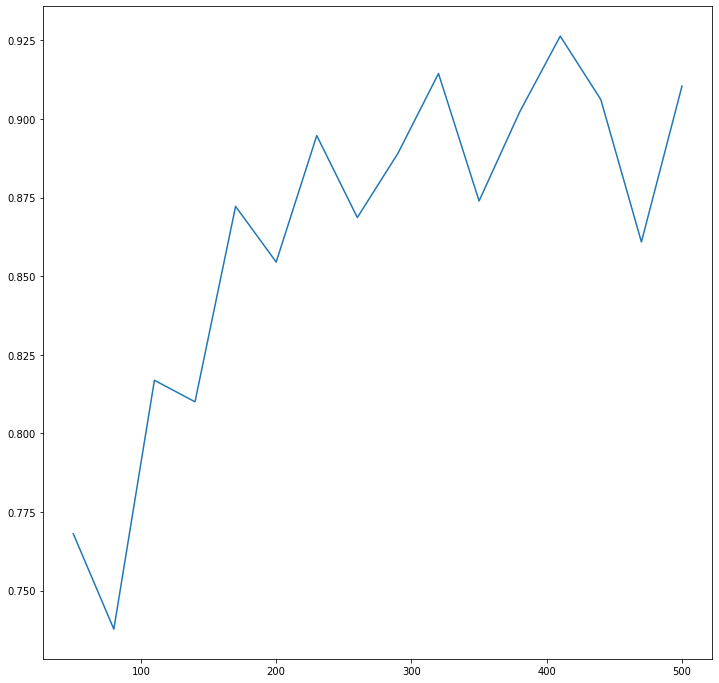

In [32]:
plt.figure(figsize=(12, 12))
plt.plot(train_num, list(map(lambda x: x[1],scores)))

In [22]:
feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
xgb_cmodel = XGBClassifier()

X_train, X_test = X[:400], X[400:]
y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:400]))
y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[400:]))

X_train = feature_extractor.fit_transform(X_train)
X_test = feature_extractor.fit_transform(X_test)

xgb_cmodel.fit(X_train, y_train)

y_pred = xgb_cmodel.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
score

0.8879187854155478

In [23]:
def get_feature_names(names):
    feature_names = names.copy()
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_prev_' + name)
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_next_' + name)
    return feature_names

In [24]:
feature_names = get_feature_names(['left', 'top', 'wigth', 'height', 
                'mean_left', 'mean_height', 'mean_width',
                'line_color', 'avg_color',
                'bold2', 'bold3', 'bold4', 'bold5', 'bold6', 'bold7',
                'reg1', 'reg2',
                'reg3', 'reg4', 'reg5', 'reg6', 'reg7',
                'reg8', 'reg9', 'reg10', 'reg11',
                'end_reg1', 'end_reg2', 'end_reg3', 'end_reg4', 'end_reg5',
                'word_letters_cnt', 'line_cnt', 'word_cnt', 'mean_line_cnt',
                'mean_line_color', 'mean_bold2', 
                'mean_bold3', 'mean_bold4', 'mean_bold5',
                'mean_bold6', 'mean_bold7'])

xgbfir.saveXgbFI(xgb_cmodel, feature_names=feature_names, 
                 OutputXlsxFile='fearures_importances.xlsx')

X_test [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]

In [27]:
X_train, X_test = X[:400], X[400:]

d = {}
i = 0
for doc_info in X_test:
    for line_info in doc_info['entities']:
        d[(tuple(line_info['bbox']), doc_info['name'], line_info["text"])] = [y_test[i], y_pred[i]]
        i += 1

In [28]:
color_dict = {
    1 : (0, 0, 255),
    2 : (0, 255, 0),
    3 : (255, 0, 0),
    4 : (0, 255, 255)
}
class2label = {
    1: "header", 
    2: "list", 
    3: "text", 
    4: "other"
}

grouped_by_dock = defaultdict(list)
for item in d.items():
    key, (real_class, predicted_class) = item
    file_name = key[1]
    grouped_by_dock[file_name].append(item)


for file_name, items in tqdm(grouped_by_dock.items()):
    
    img = None 
    for key, (real_class, predicted_class) in items:        
        if real_class != predicted_class:
            print(key[2])
            print()
            if img is None:
                img = cv2.imread('docs/' + file_name)
            (x, y, w, h) = key[0]
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
            cv2.putText(img, class2label[predicted_class] + " " + class2label[real_class], 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                        color_dict[predicted_class], 2)
    if img is not None:
        cv2.imwrite('different_docs/' + file_name, img)        

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Начальник СТОС Wy С.Н. Кирюшин

5.10.3. решение о допуске Участника процедуры закупки к участию в запросе предложений и о

® условия оплаты - 10 (ОЪазс);

3 В случае, если хотя бы один из Участников является налогоплательщиком, применяющим упрощенную систему

7. Мероприятия по контролю качества разрешительной, проектной

(рабочей), проектов производства работ (технологических регламентов),

исполнительной документации.

занесенные в общий журнал производства работ.

(описание вида производства работ, ведение исполнительной документации,

Дополнительная информация:

Приложение к конкурсной документации:



И.о. начальника УЗ Л.Г. Возчикова

испокон еее

5.2.3. Надлежаще исполнять иные принятые на себя обязательства.

6.2. Поставщик по настоящему Договору обязан:

6.2.5. Надлежаще исполнять иные принятые на себя обязательств.

4. Участник закупки подтверждает, что согласен выполнить работы, являющиеся предметом

М.П. (для юридических лиц)

'рузка осуществляется силами Грузополучателя (са